In [129]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# 데이터 로드
der = pd.read_csv("C:/Users/symply_jina/Desktop/seohyun/UIC4801/der.csv")
der['datetime_beginning_ept'] = pd.to_datetime(der['datetime_beginning_ept'], format='%m/%d/%Y %I:%M:%S %p')

# 주요 변수 설정
I = list(range(0, 15))  # DER 수
T = list(range(len(der.groupby(der['datetime_beginning_ept'].dt.hour).groups.keys())))  # 시간대 수 (24시간)
S = list(range(len(der.groupby(der['datetime_beginning_ept'].dt.date).groups.keys())))  # 날짜별 시나리오 인덱스


In [130]:
# 전일 시장 가격 (Day-ahead) 및 실시간 시장 가격 (Real-time)
P_DA = {t: sum(der['system_energy_price_da'].iloc[t + s * len(T)] for s in S) / len(S) for t in T}
P_RT = {(t, s): der['system_energy_price_rt'].iloc[t + s * len(T)] for t in T for s in S}

# 패널티 비용 계산
P_PN = {(t, s): max(P_DA[t], P_RT[(t, s)]) * 2 for t in T for s in S}

# 시나리오 확률 계산
prob = {s: 1 / len(S) for s in S}

In [131]:
# plt.figure(figsize=(12, 6))
# plt.plot([t for t in T], [P_DA[t] for t in T], 'b-', label='DA price')
# plt.plot([t for t in T], [sum(P_RT[t,s] for s in S)/len(S) for t in T], 'r--', label='RT price')
# plt.plot([t for t in T], [sum(P_PN[t,s] for s in S)/len(S) for t in T], 'g:', label='Penalty price')
# plt.title('Price Data')
# plt.xlabel('time')
# plt.ylabel('price')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [132]:
# DER 발전량 데이터 생성 (시간대 및 시나리오별 변동 포함)
np.random.seed(17)
R = {
    (i, t, s): max(
        0,
        10 + 3 * np.random.normal(0, 1)
    )
    for i in I for t in T for s in S
}

In [133]:
# ==============================
# Case 2: DER with Aggregation
# ==============================
x_DA_2 = {(i, t): cp.Variable(pos=True) for i in I for t in T}
y_plus_2 = {(i, t, s): cp.Variable(pos=True) for i in I for t in T for s in S}
y_minus_2 = {(i, t, s): cp.Variable(pos=True) for i in I for t in T for s in S}
alpha_DA = {t: cp.Variable(pos=True) for t in T}
beta_plus = {(t, s): cp.Variable(pos=True) for t in T for s in S}
beta_minus = {(t, s): cp.Variable(pos=True) for t in T for s in S}

# Case 2 목적함수
obj_case2 = sum(
    P_DA[t] * alpha_DA[t] for t in T
) + sum(
    prob[s] * (P_RT[t, s] * beta_plus[t, s] - P_PN[t, s] * beta_minus[t, s])
    for t in T for s in S
)

# Case 2 제약조건
constraints_case2 = []
for i in I:
    for t in T:
        for s in S:
            constraints_case2.append(R[i, t, s] - x_DA_2[i, t] == y_plus_2[i, t, s] - y_minus_2[i, t, s])

for t in T:
    constraints_case2.append(alpha_DA[t] == sum(x_DA_2[i, t] for i in I))

for t in T:
    for s in S:
        constraints_case2.append(sum(R[i, t, s] for i in I) - alpha_DA[t] == beta_plus[t, s] - beta_minus[t, s])

for t in T:
    for s in S:
        constraints_case2.append(beta_plus[t, s] - beta_minus[t, s] == sum(y_plus_2[i, t, s] - y_minus_2[i, t, s] for i in I))

M=10000

# y+, y- / beta+, beta-의 동시 발생 방지
z_case2 = {(i, t, s): cp.Variable(boolean=True) for i in I for t in T for s in S}
z_beta = {(t, s): cp.Variable(boolean=True) for t in T for s in S}
for i in I:
    for t in T:
        for s in S:
            constraints_case2.append(y_plus_2[i, t, s] <= M * z_case2[i, t, s])
            constraints_case2.append(y_minus_2[i, t, s] <= M * (1 - z_case2[i, t, s]))
for t in T:
    for s in S:
        constraints_case2.append(beta_plus[t, s] <= M * z_beta[t, s])
        constraints_case2.append(beta_minus[t, s] <= M * (1 - z_beta[t, s]))

In [134]:
# =========================
# 문제 정의 및 최적화 실행
# =========================
prob_case2 = cp.Problem(cp.Maximize(obj_case2), constraints_case2)

# 풀이 실행
prob_case2.solve(solver='GUROBI')

# 결과 출력
print("Case 2 최적해:")
print(f"총 이익: {prob_case2.value}")

Case 2 최적해:
총 이익: 116663.56211721439


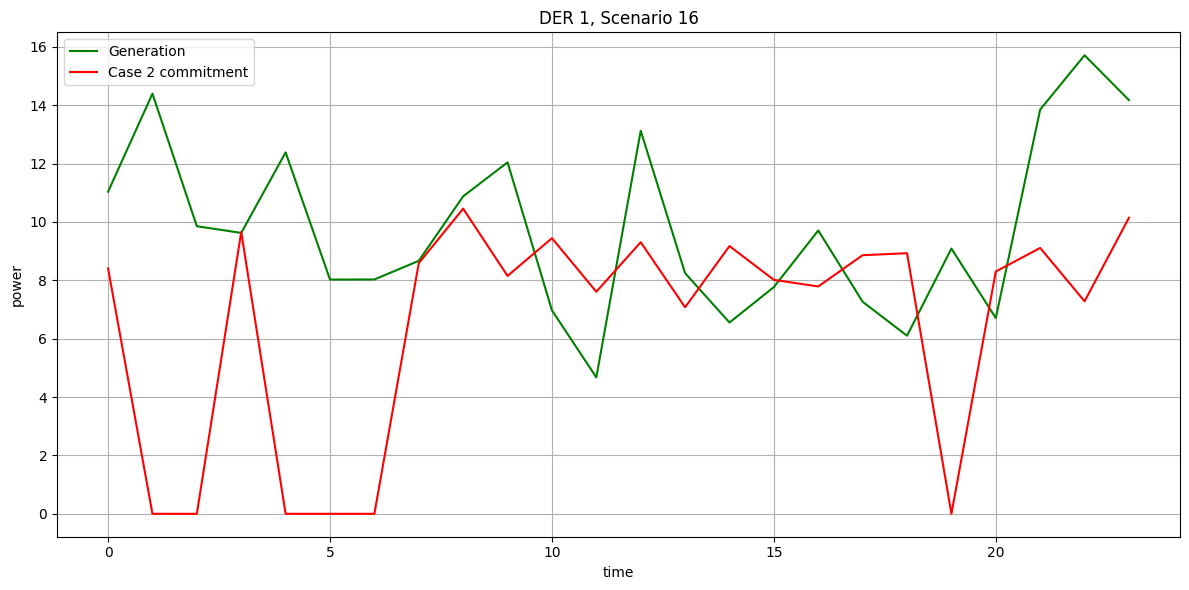

In [135]:
plt.figure(figsize=(12, 6))

i, s = 1, 16
plt.plot([t for t in T], [R[i,t,s] for t in T], 'g-', label='Generation')
plt.plot([t for t in T], [x_DA_2[i,t].value for t in T], 'r-', label='Case 2 commitment')
# plt.plot([t for t in T], [y_plus_2[i,t,s].value for t in T], 'r:', label='Case 2 y+')

plt.title(f'DER {i}, Scenario {s}')
plt.xlabel('time')
plt.ylabel('power')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [136]:
# i별 평균 commitment 계산
print("\n각 DER별 하루 평균 commitment 분석:")
for i in I:

    # Case 2 평균값 계산
    case2_commitment = sum(x_DA_2[i,t].value for t in T)
    
    print(f"\nDER {i}:")
    print(f"  Case 2 평균 commitment: {case2_commitment:.2f} MW")


각 DER별 하루 평균 commitment 분석:

DER 0:
  Case 2 평균 commitment: 159.33 MW

DER 1:
  Case 2 평균 commitment: 156.31 MW

DER 2:
  Case 2 평균 commitment: 166.46 MW

DER 3:
  Case 2 평균 commitment: 158.58 MW

DER 4:
  Case 2 평균 commitment: 161.07 MW

DER 5:
  Case 2 평균 commitment: 155.33 MW

DER 6:
  Case 2 평균 commitment: 159.44 MW

DER 7:
  Case 2 평균 commitment: 161.55 MW

DER 8:
  Case 2 평균 commitment: 164.56 MW

DER 9:
  Case 2 평균 commitment: 156.42 MW

DER 10:
  Case 2 평균 commitment: 153.95 MW

DER 11:
  Case 2 평균 commitment: 159.01 MW

DER 12:
  Case 2 평균 commitment: 160.17 MW

DER 13:
  Case 2 평균 commitment: 158.91 MW

DER 14:
  Case 2 평균 commitment: 160.06 MW


In [137]:
# 각 시간과 시나리오에 대한 모든 der의 y+와 y-의 합, beta 확인
print("\n각 시간과 시나리오에 대한 모든 der의 y+와 y-의 합, beta 분석:")
for t in T:
    for s in S:
        total_y_plus = sum(y_plus_2[i, t, s].value for i in I)
        total_y_minus = sum(y_minus_2[i, t, s].value for i in I)
        print(f"\n시간 {t}, 시나리오 {s}:")
        print(f"  모든 der의 y_plus_2 합: {total_y_plus:.2f}")
        print(f"  모든 der의 y_minus_2 합: {total_y_minus:.2f}")
        print(f"  beta_plus: {beta_plus[t, s].value:.2f}")
        print(f"  beta_minus: {beta_minus[t, s].value:.2f}")


각 시간과 시나리오에 대한 모든 der의 y+와 y-의 합, beta 분석:

시간 0, 시나리오 0:
  모든 der의 y_plus_2 합: 45.57
  모든 der의 y_minus_2 합: 7.52
  beta_plus: 38.05
  beta_minus: 0.00

시간 0, 시나리오 1:
  모든 der의 y_plus_2 합: 34.95
  모든 der의 y_minus_2 합: 10.00
  beta_plus: 24.95
  beta_minus: 0.00

시간 0, 시나리오 2:
  모든 der의 y_plus_2 합: 25.10
  모든 der의 y_minus_2 합: 12.86
  beta_plus: 12.24
  beta_minus: 0.00

시간 0, 시나리오 3:
  모든 der의 y_plus_2 합: 34.61
  모든 der의 y_minus_2 합: 5.80
  beta_plus: 28.81
  beta_minus: 0.00

시간 0, 시나리오 4:
  모든 der의 y_plus_2 합: 23.66
  모든 der의 y_minus_2 합: 11.50
  beta_plus: 12.16
  beta_minus: 0.00

시간 0, 시나리오 5:
  모든 der의 y_plus_2 합: 40.23
  모든 der의 y_minus_2 합: 9.11
  beta_plus: 31.12
  beta_minus: 0.00

시간 0, 시나리오 6:
  모든 der의 y_plus_2 합: 29.31
  모든 der의 y_minus_2 합: 4.17
  beta_plus: 25.14
  beta_minus: 0.00

시간 0, 시나리오 7:
  모든 der의 y_plus_2 합: 20.93
  모든 der의 y_minus_2 합: 10.61
  beta_plus: 10.32
  beta_minus: 0.00

시간 0, 시나리오 8:
  모든 der의 y_plus_2 합: 23.24
  모든 der의 y_minus_2 합: 7.84
  beta_pl

In [138]:
# obj_case2 = sum(
#     P_DA[t] * alpha_DA[t] for t in T
# ) + sum(
#     prob[s] * (P_RT[t, s] * beta_plus[t, s] - P_PN[t, s] * beta_minus[t, s])
#     for t in T for s in S
# )

In [139]:
# 모든 der의 profit 합계 계산 (Case 2)
total_der_profit = 0
for i in I:
    # 각 der i의 profit 합계 계산 (Case 2)
    der_profit = sum(P_DA[t] * x_DA_2[i,t].value + sum(prob[s] * (P_RT[t,s] * y_plus_2[i,t,s].value - P_PN[t,s] * y_minus_2[i,t,s].value) for s in S) for t in T)
    total_der_profit += der_profit
    print(i, der_profit)

print(f"\n모든 der의 profit 합계 (Case 2): {total_der_profit:.2f}")


0 7297.149487303368
1 7357.088694298515
2 7588.178462459539
3 7390.4071461543535
4 7245.083412402196
5 7598.258245606607
6 7215.8163129815575
7 7265.396311266674
8 7178.793190839768
9 7041.167776485867
10 7314.7651173641825
11 7270.793617192132
12 7269.283850733041
13 7163.1146259608195
14 7441.371439180305

모든 der의 profit 합계 (Case 2): 109636.67


In [140]:
total_der_da = 0
for t in T:
    der_da = P_DA[t] * (sum(x_DA_2[i,t].value for i in I) - alpha_DA[t].value)
    total_der_da += der_da
    print(i, der_da)

print(f"\ncommitment 양 차이에 따른 profit: {total_der_da:.2f}")

14 0.0
14 1.509643277769658e-10
14 3.161622430525313e-10
14 2.1172339866978058e-12
14 5.369711637344623e-10
14 5.256980539769528e-10
14 2.737057147236732e-10
14 -9.694186672042573e-13
14 -8.41612657701086e-13
14 0.0
14 -7.884640610662305e-13
14 -7.68999774253086e-13
14 -7.484261239428195e-13
14 3.7259027404586725e-13
14 0.0
14 0.0
14 1.4739865242342106e-12
14 -1.0852508855732007e-12
14 0.0
14 2.1254498204458996e-10
14 -5.585966098278147e-13
14 -5.604944465542963e-13
14 6.209318364140456e-13
14 0.0

commitment 양 차이에 따른 profit: 0.00


In [141]:
# Day-ahead 수익 비교
total_da_profit_obj = 0
for t in T:
    total_da_profit_obj += P_DA[t] * alpha_DA[t].value

# Real-time 수익 비교
total_rt_profit_obj = 0
for t in T:
    for s in S:
        rt_profit_obj = P_RT[t, s] * beta_plus[t, s].value
        total_rt_profit_obj += prob[s] * rt_profit_obj

# 패널티 비용 비교
total_penalty_cost_obj = 0
for t in T:
    for s in S:
        penalty_cost_obj = P_PN[t, s] * beta_minus[t, s].value
        total_penalty_cost_obj += prob[s] * penalty_cost_obj

# 총 시스템 이익 (목적 함수 기반)
total_system_profit_obj = total_da_profit_obj + total_rt_profit_obj - total_penalty_cost_obj

# 결과 출력
print(f"총 Day-ahead 수익 (_obj): {total_da_profit_obj:.2f}")
print(f"총 Real-time 수익 (_obj): {total_rt_profit_obj:.2f}")
print(f"총 Penalty 비용 (_obj): {total_penalty_cost_obj:.2f}")
print(f"목적 함수 기반 총 이익 (_obj): {total_system_profit_obj:.2f}")


총 Day-ahead 수익 (_obj): 69666.43
총 Real-time 수익 (_obj): 47431.02
총 Penalty 비용 (_obj): 433.89
목적 함수 기반 총 이익 (_obj): 116663.56


In [142]:
print("Case 2 최적해:")
print(f"총 이익: {prob_case2.value}")

Case 2 최적해:
총 이익: 116663.56211721439


In [143]:
# Day-ahead, Real-time, Penalty 별 Profit 합계
total_da_profit_der = 0
total_rt_profit_der = 0
total_penalty_cost_der = 0

for i in I:
    for t in T:
        # Day-ahead 수익 계산
        total_da_profit_der += P_DA[t] * x_DA_2[i, t].value
        
        for s in S:
            # Real-time 수익 계산
            total_rt_profit_der += prob[s] * P_RT[t, s] * y_plus_2[i, t, s].value
            
            # Penalty 비용 계산
            total_penalty_cost_der += prob[s] * P_PN[t, s] * y_minus_2[i, t, s].value

# 총 합계 계산
total_der_profit_der = total_da_profit_der + total_rt_profit_der - total_penalty_cost_der

# 결과 출력
print(f"총 Day-ahead 수익 (_der): {total_da_profit_der:.2f}")
print(f"총 Real-time 수익 (_der): {total_rt_profit_der:.2f}")
print(f"총 Penalty 비용 (_der): {total_penalty_cost_der:.2f}")
print(f"모든 DER의 Profit 합계 (_der): {total_der_profit_der:.2f}")


총 Day-ahead 수익 (_der): 69666.43
총 Real-time 수익 (_der): 52383.67
총 Penalty 비용 (_der): 12413.44
모든 DER의 Profit 합계 (_der): 109636.67


In [144]:
# Discrepancy 계산
discrepancy_da = total_da_profit_obj - total_da_profit_der
discrepancy_rt = total_rt_profit_obj - total_rt_profit_der
discrepancy_penalty = total_penalty_cost_obj - total_penalty_cost_der
discrepancy_total = total_system_profit_obj - total_der_profit_der

# 결과 출력 
print(f"Day-ahead 수익 Discrepancy: {discrepancy_da:.2f}")
print(f"Real-time 수익 Discrepancy: {discrepancy_rt:.2f}")
print(f"Penalty 비용 Discrepancy: {discrepancy_penalty:.2f}")
print(f"총 이익 Discrepancy: {discrepancy_total:.2f}")


Day-ahead 수익 Discrepancy: -0.00
Real-time 수익 Discrepancy: -4952.65
Penalty 비용 Discrepancy: -11979.54
총 이익 Discrepancy: 7026.89


In [145]:
# i별 평균 profit 계산
print("\n각 DER별 하루 평균 profit 분석:")
for i in I:
    
    # Case 2 profit 계산 
    case2_profit = sum(
        P_DA[t] * x_DA_2[i,t].value for t in T
    ) + sum(
        prob[s] * (P_RT[t, s] * y_plus_2[i,t,s] - P_PN[t, s] * y_minus_2[i,t,s])
        for t in T for s in S
    )
    
    print(f"\nDER {i}:")
    for t in T:
        print(f"  시간 {t}:")
        print(f"    P_DA: {P_DA[t]:.2f} (x_DA_2: {x_DA_2[i,t].value:.2f})")
        for s in S:
            print(f"    시나리오 {s}:")
            print(f"      R: {R[i,t,s]:.2f}") 
            print(f"      P_RT: {prob[s] * P_RT[t, s]:.2f} (y_plus_2: {y_plus_2[i,t,s].value:.2f})")
            print(f"      P_PN: {prob[s] * P_PN[t, s]:.2f} (y_minus_2: {y_minus_2[i,t,s].value:.2f})")
        # 각 시간별 profit 계산 및 출력
        time_profit = P_DA[t] * x_DA_2[i,t].value + sum(prob[s] * (P_RT[t, s] * y_plus_2[i,t,s].value - P_PN[t, s] * y_minus_2[i,t,s].value) for s in S)
        print(f"    시간 {t}의 profit: {time_profit:.2f}")
    print(f"  DER {i}의 Case 2 평균 profit: {case2_profit.value:.2f}")


각 DER별 하루 평균 profit 분석:

DER 0:
  시간 0:
    P_DA: 25.81 (x_DA_2: 8.69)
    시나리오 0:
      R: 10.83
      P_RT: 0.58 (y_plus_2: 2.14)
      P_PN: 1.66 (y_minus_2: 0.00)
    시나리오 1:
      R: 4.44
      P_RT: 0.54 (y_plus_2: 0.00)
      P_PN: 1.66 (y_minus_2: 4.25)
    시나리오 2:
      R: 11.87
      P_RT: 0.50 (y_plus_2: 3.19)
      P_PN: 1.66 (y_minus_2: 0.00)
    시나리오 3:
      R: 13.44
      P_RT: 0.58 (y_plus_2: 4.75)
      P_PN: 1.66 (y_minus_2: 0.00)
    시나리오 4:
      R: 13.11
      P_RT: 0.74 (y_plus_2: 4.42)
      P_PN: 1.66 (y_minus_2: 0.00)
    시나리오 5:
      R: 15.66
      P_RT: 0.80 (y_plus_2: 6.97)
      P_PN: 1.66 (y_minus_2: 0.00)
    시나리오 6:
      R: 9.66
      P_RT: 0.82 (y_plus_2: 0.98)
      P_PN: 1.66 (y_minus_2: 0.00)
    시나리오 7:
      R: 8.91
      P_RT: 0.99 (y_plus_2: 0.23)
      P_PN: 1.98 (y_minus_2: 0.00)
    시나리오 8:
      R: 10.45
      P_RT: 0.92 (y_plus_2: 1.76)
      P_PN: 1.84 (y_minus_2: 0.00)
    시나리오 9:
      R: 8.69
      P_RT: 0.72 (y_plus_2: 0.00)
      P